# Water Potability prediction Fractal Hackathon

### Import required libraries 

In [1]:
# Import the must required librarires....

import pandas as pd
import numpy as np

# import libraries for visuallization of the data....
import seaborn as sns
import matplotlib.pyplot as plt

# import library for statistical analysis....
import scipy.stats as stats
import statsmodels.formula.api as sfa
from statsmodels.stats.anova import anova_lm
from scipy.stats import chi2_contingency

# for splitting the data...
from sklearn.model_selection import train_test_split

# import librarires for modelling purpose...
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,BaggingRegressor,AdaBoostRegressor,StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor

# import libraries for model eavaluation....
from sklearn.metrics import roc_auc_score,precision_score,classification_report,recall_score,accuracy_score
from sklearn import metrics
# import the warnings library for ignoring warnings by that notebook does not look like dense filled..
import warnings
warnings.filterwarnings('ignore')

#### load the dataset

In [2]:
train  = pd.read_csv('train.csv')

In [3]:
test = pd.read_csv('test.csv')

In [4]:
df = pd.concat([train,test],ignore_index=True)

In [5]:
df.head(2)

,Index,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0,<p>😅The pH value observed is: 0.2644088544860...,<br>😒With a hardness level of 2.6735383052025...,<br>😅The water sample exhibits a total solids ...,1.431972,1.303685,1.563001,0.697062,2.010126,<h1>😀Observing a turbidity value of 1.60887258...,1.252351
1,1,<p>😇The solution's pH level is 0.012034498894...,<h1>😀The water hardness is measured at 2.6303...,<br>😒The total solids content in the sample is...,0.911372,1.181754,1.741640,0.896108,1.807786,<br>😁The water sample exhibits a turbidity rea...,1.124565


### Missing values treatment:

In [6]:
df.isna().sum()

Index                 0
ph                    0
Hardness              0
Solids                0
Chloramines           0
Sulfate               0
Conductivity          0
Organic_carbon        0
Trihalomethanes       0
Turbidity             0
Potability         5000
dtype: int64

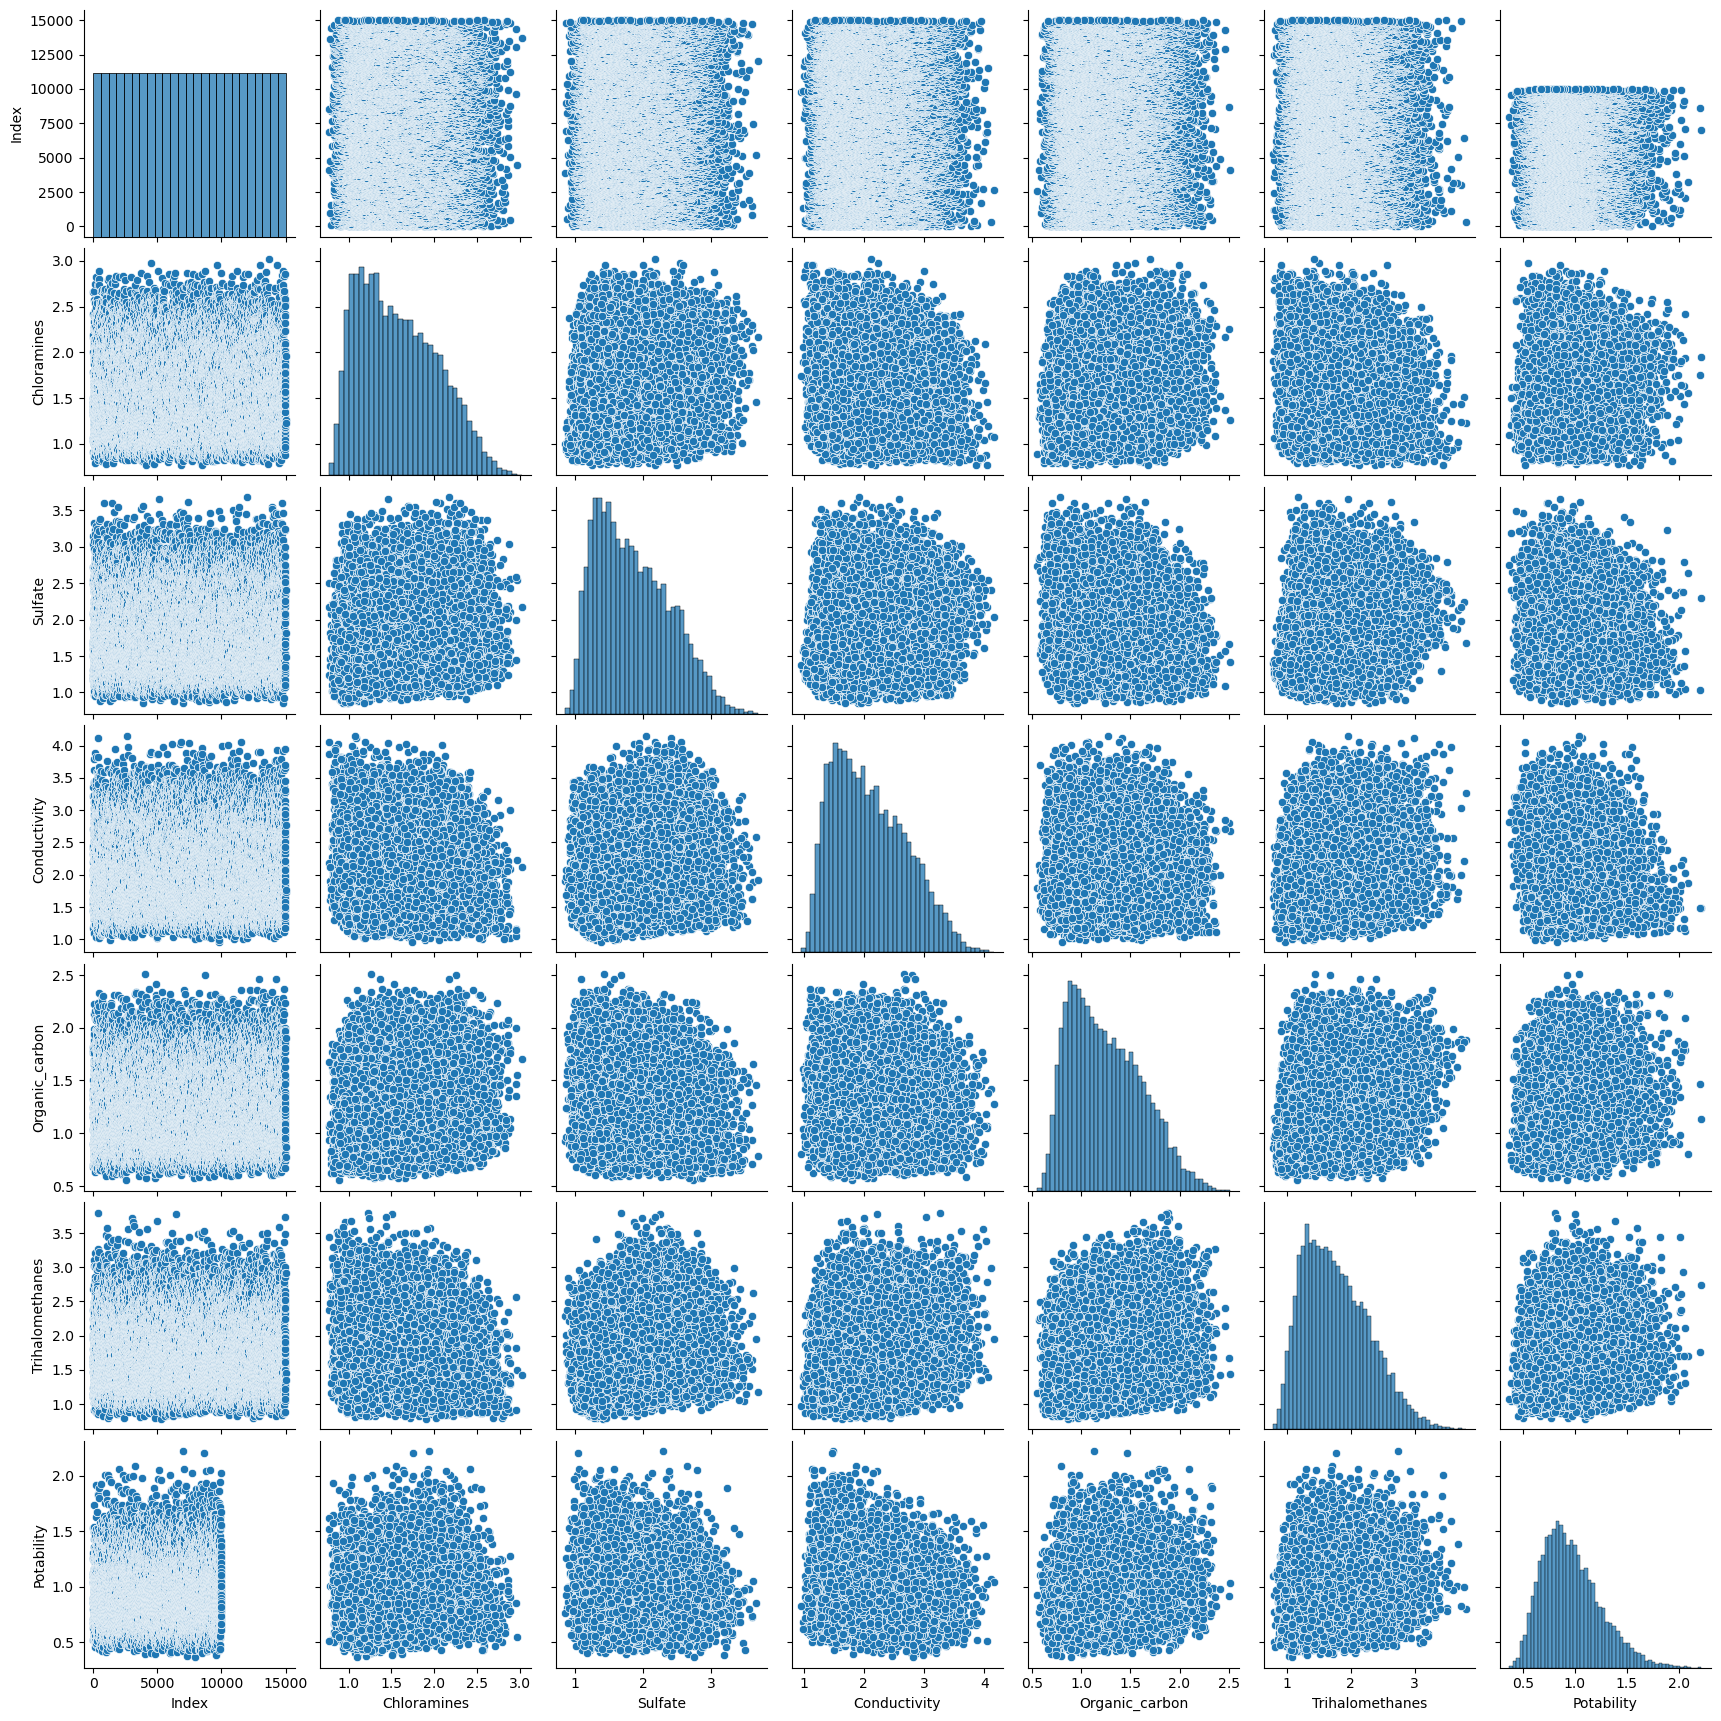

In [7]:
sns.pairplot(df);

In [10]:
import re
def extract_ph_value_and_text(text):
    # Step 1: Remove HTML tags using regex
    clean_text = re.sub(r'<.*?>', '', text)
    
    # Step 2: Extract the pH value (floating-point number)
    ph_value = re.search(r'(\d+\.\d+)', clean_text)
    ph_value = float(ph_value.group(1)) if ph_value else None
    
    # Step 3: Extract the text after the pH value
    text_after_ph = re.split(r'\d+\.\d+', clean_text)[-1].strip()
    
    return ph_value, text_after_ph[:-1]

# Apply the function to the 'ph' column
df[['ph_value', 'text_after_ph']] = df['ph'].apply(lambda x: pd.Series(extract_ph_value_and_text(x)))

df.head(2)

,Index,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,ph_value,text_after_ph
0,0,<p>😅The pH value observed is: 0.2644088544860...,<br>😒With a hardness level of 2.6735383052025...,<br>😅The water sample exhibits a total solids ...,1.431972,1.303685,1.563001,0.697062,2.010126,<h1>😀Observing a turbidity value of 1.60887258...,1.252351,0.264409,indicating a slightly alkaline solution
1,1,<p>😇The solution's pH level is 0.012034498894...,<h1>😀The water hardness is measured at 2.6303...,<br>😒The total solids content in the sample is...,0.911372,1.181754,1.741640,0.896108,1.807786,<br>😁The water sample exhibits a turbidity rea...,1.124565,0.012034,indicating it's leaning towards the alkaline s...


In [11]:
df['ph'][8885]

"<h2>😒The water sample's pH level is  0.5239559332055815 falling within the acceptable range for drinking water.😒</h2>"

In [12]:
df['ph_value'][8885]

0.5239559332055815

In [13]:
df['ph'][0].split(str(df['ph_value'][0]))[1][:-5]

' indicating a slightly alkaline solution'

In [14]:
df['text_after_ph'][0]

'indicating a slightly alkaline solution'

In [15]:
def extract_hardness_value_and_text(text):
    # Step 1: Remove HTML tags using regex
    clean_text = re.sub(r'<.*?>', '', text)
    
    # Step 2: Extract the harness value (floating-point number)
    ha_value = re.search(r'(\d+\.\d+)', clean_text)
    ha_value = float(ha_value.group(1)) if ha_value else None
    
    # Step 3: Extract the text after the ha value
    text_after_ha = re.split(r'\d+\.\d+', clean_text)[-1].strip()
    
    return ha_value, text_after_ha[:-1]

df[['ha_value', 'text_after_ha']] = df['Hardness'].apply(lambda x: pd.Series(extract_hardness_value_and_text(x)))

df.head(3)

,Index,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,ph_value,text_after_ph,ha_value,text_after_ha
0,0,<p>😅The pH value observed is: 0.2644088544860...,<br>😒With a hardness level of 2.6735383052025...,<br>😅The water sample exhibits a total solids ...,1.431972,1.303685,1.563001,0.697062,2.010126,<h1>😀Observing a turbidity value of 1.60887258...,1.252351,0.264409,indicating a slightly alkaline solution,2.673538,this water falls into the category of hard water.
1,1,<p>😇The solution's pH level is 0.012034498894...,<h1>😀The water hardness is measured at 2.6303...,<br>😒The total solids content in the sample is...,0.911372,1.181754,1.741640,0.896108,1.807786,<br>😁The water sample exhibits a turbidity rea...,1.124565,0.012034,indicating it's leaning towards the alkaline s...,2.630323,indicating moderately hard water.
2,2,<br>😀The pH reading measures 0.491167423175516...,<h2>😅With a hardness level of 1.2213782428674...,<h1>😍The water sample exhibits a total solids ...,1.506492,1.700871,2.322337,1.035440,1.548768,<p>😇Observing a turbidity value of 1.008907465...,0.525886,0.491167,suggesting a moderately alkaline composition.,1.221378,this water falls into the category of hard water.


In [16]:
def extract_solid_value_and_text(text):
    # Step 1: Remove HTML tags using regex
    clean_text = re.sub(r'<.*?>', '', text)
    
    # Step 2: Extract the solid value (floating-point number)
    solid_value = re.search(r'(\d+\.\d+)', clean_text)
    solid_value = float(solid_value.group(1)) if solid_value else None
    
    # Step 3: Extract the text after the solid value
    text_after_solid = re.split(r'\d+\.\d+', clean_text)[-1].strip()
    
    return solid_value, text_after_solid[:-1]

df[['solid_value', 'text_after_solid']] = df['Solids'].apply(lambda x: pd.Series(extract_solid_value_and_text(x)))

df.head(3)

,Index,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,ph_value,text_after_ph,ha_value,text_after_ha,solid_value,text_after_solid
0,0,<p>😅The pH value observed is: 0.2644088544860...,<br>😒With a hardness level of 2.6735383052025...,<br>😅The water sample exhibits a total solids ...,1.431972,1.303685,1.563001,0.697062,2.010126,<h1>😀Observing a turbidity value of 1.60887258...,1.252351,0.264409,indicating a slightly alkaline solution,2.673538,this water falls into the category of hard water.,2.336743,indicating relatively low suspended matter.
1,1,<p>😇The solution's pH level is 0.012034498894...,<h1>😀The water hardness is measured at 2.6303...,<br>😒The total solids content in the sample is...,0.911372,1.181754,1.741640,0.896108,1.807786,<br>😁The water sample exhibits a turbidity rea...,1.124565,0.012034,indicating it's leaning towards the alkaline s...,2.630323,indicating moderately hard water.,2.495853,suggesting a significant concentration.
2,2,<br>😀The pH reading measures 0.491167423175516...,<h2>😅With a hardness level of 1.2213782428674...,<h1>😍The water sample exhibits a total solids ...,1.506492,1.700871,2.322337,1.035440,1.548768,<p>😇Observing a turbidity value of 1.008907465...,0.525886,0.491167,suggesting a moderately alkaline composition.,1.221378,this water falls into the category of hard water.,1.438038,indicating relatively low suspended matter.


In [17]:
df['Turbidity'][0]

'<h1>😀Observing a turbidity value of 1.608872586633192  this water carries a moderate level of suspended particles.😀</h1>'

In [18]:
def extract_turbidity_value_and_text(text):
    # Step 1: Remove HTML tags using regex
    clean_text = re.sub(r'<.*?>', '', text)
    
    # Step 2: Extract the turbidity value (floating-point number)
    turbidity_value = re.search(r'(\d+\.\d+)', clean_text)
    turbidity_value = float(ph_value.group(1)) if turbidity_value else None
    
    # Step 3: Extract the text after the turbidity value
    text_after_turbidity = re.split(r'\d+\.\d+', clean_text)[-1].strip()
    
    return turbidity_value, text_after_turbidity[:-1]

df[['turbidity_value', 'text_after_turbidity']] = df['Turbidity'].apply(lambda x: pd.Series(extract_ph_value_and_text(x)))

df.head(3)

,Index,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,ph_value,text_after_ph,ha_value,text_after_ha,solid_value,text_after_solid,turbidity_value,text_after_turbidity
0,0,<p>😅The pH value observed is: 0.2644088544860...,<br>😒With a hardness level of 2.6735383052025...,<br>😅The water sample exhibits a total solids ...,1.431972,1.303685,1.563001,0.697062,2.010126,<h1>😀Observing a turbidity value of 1.60887258...,1.252351,0.264409,indicating a slightly alkaline solution,2.673538,this water falls into the category of hard water.,2.336743,indicating relatively low suspended matter.,1.608873,this water carries a moderate level of suspend...
1,1,<p>😇The solution's pH level is 0.012034498894...,<h1>😀The water hardness is measured at 2.6303...,<br>😒The total solids content in the sample is...,0.911372,1.181754,1.741640,0.896108,1.807786,<br>😁The water sample exhibits a turbidity rea...,1.124565,0.012034,indicating it's leaning towards the alkaline s...,2.630323,indicating moderately hard water.,2.495853,suggesting a significant concentration.,1.478430,indicating slightly cloudy water.
2,2,<br>😀The pH reading measures 0.491167423175516...,<h2>😅With a hardness level of 1.2213782428674...,<h1>😍The water sample exhibits a total solids ...,1.506492,1.700871,2.322337,1.035440,1.548768,<p>😇Observing a turbidity value of 1.008907465...,0.525886,0.491167,suggesting a moderately alkaline composition.,1.221378,this water falls into the category of hard water.,1.438038,indicating relatively low suspended matter.,1.008907,this water carries a moderate level of suspend...


In [19]:
df.isna().sum()

Index                      0
ph                         0
Hardness                   0
Solids                     0
Chloramines                0
Sulfate                    0
Conductivity               0
Organic_carbon             0
Trihalomethanes            0
Turbidity                  0
Potability              5000
ph_value                   0
text_after_ph              0
ha_value                   0
text_after_ha              0
solid_value                0
text_after_solid           0
turbidity_value            0
text_after_turbidity       0
dtype: int64

In [20]:
df.duplicated().sum()

0

In [21]:
df1 = df.drop(columns = ['Index','ph','Hardness','Solids','Turbidity'])

In [22]:
for i in ['text_after_ph','text_after_ha','text_after_solid','text_after_turbidity']:
    print(df[i].value_counts())
    print('-----------------------------------')

indicating a slightly alkaline solution                               3117
indicates a slightly acidic substance.                                3032
falling within the acceptable range for drinking water.               2971
indicating it's leaning towards the alkaline side of the pH scale.    2941
suggesting a moderately alkaline composition.                         2937
e-05  indicates a slightly acidic substance.                             2
Name: text_after_ph, dtype: int64
-----------------------------------
indicating moderately hard water.                    5060
this water falls into the category of hard water.    4976
signifies moderately soft water.                     4964
Name: text_after_ha, dtype: int64
-----------------------------------
this water contains a moderate amount of suspended particles.    5068
indicating relatively low suspended matter.                      4986
suggesting a significant concentration.                          4946
Name: text_after_solid, dt

### Statistical Tests:

In [23]:
df1.head()

,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Potability,ph_value,text_after_ph,ha_value,text_after_ha,solid_value,text_after_solid,turbidity_value,text_after_turbidity
0,1.431972,1.303685,1.563001,0.697062,2.010126,1.252351,0.264409,indicating a slightly alkaline solution,2.673538,this water falls into the category of hard water.,2.336743,indicating relatively low suspended matter.,1.608873,this water carries a moderate level of suspend...
1,0.911372,1.181754,1.741640,0.896108,1.807786,1.124565,0.012034,indicating it's leaning towards the alkaline s...,2.630323,indicating moderately hard water.,2.495853,suggesting a significant concentration.,1.478430,indicating slightly cloudy water.
2,1.506492,1.700871,2.322337,1.035440,1.548768,0.525886,0.491167,suggesting a moderately alkaline composition.,1.221378,this water falls into the category of hard water.,1.438038,indicating relatively low suspended matter.,1.008907,this water carries a moderate level of suspend...
3,2.658852,3.035266,2.409255,1.185713,1.232375,0.715288,0.486553,falling within the acceptable range for drinki...,1.259134,this water falls into the category of hard water.,1.151006,suggesting a significant concentration.,1.249935,indicating slightly cloudy water.
4,2.169616,1.520531,1.990604,1.237182,1.589307,0.890722,0.075488,indicates a slightly acidic substance.,1.656818,this water falls into the category of hard water.,1.095344,suggesting a significant concentration.,1.515182,indicating slightly cloudy water.


In [24]:
import scipy.stats as stats
import statsmodels.formula.api as sfa
from statsmodels.stats.anova import anova_lm
from scipy.stats import chi2_contingency,shapiro,levene,kruskal,mannwhitneyu

In [25]:
p=shapiro(df1['Potability'])[1]
if p>0.05:
    print('Ho: Data is Normal')
else:
    print('Ha: Data is not Normal')
p

Ho: Data is Normal


1.0

In [26]:
df1.skew()

Chloramines        0.434559
Sulfate            0.501053
Conductivity       0.489256
Organic_carbon     0.493440
Trihalomethanes    0.566891
Potability         0.708977
ph_value           1.802735
ha_value           0.367754
solid_value        0.356366
turbidity_value    0.678127
dtype: float64

In [27]:
for i in ['Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon',
       'Trihalomethanes', 'ph_value',
       'ha_value', 'solid_value',
       'turbidity_value', ]:
    p_val = stats.ttest_ind(df1[i],train['Potability'])[1]
    print('pval',p_val,'for',i)

pval 0.0 for Chloramines
pval 0.0 for Sulfate
pval 0.0 for Conductivity
pval 0.0 for Organic_carbon
pval 0.0 for Trihalomethanes
pval 0.0 for ph_value
pval 0.0 for ha_value
pval 0.0 for solid_value
pval 0.0 for turbidity_value


In [28]:
model = sfa.ols('Potability~text_after_ph+text_after_ha+text_after_solid+text_after_turbidity',data=df1).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
text_after_ph,5.0,0.140291,0.028058,0.356959,0.878034
text_after_ha,2.0,0.108294,0.054147,0.688866,0.502169
text_after_solid,2.0,0.001529,0.000764,0.009723,0.990324
text_after_turbidity,2.0,0.050681,0.025340,0.322384,0.724427
Residual,9988.0,785.088725,0.078603,NaN,NaN


In [29]:
df2 = df1.drop(columns = ['text_after_ph','text_after_ha','text_after_solid','text_after_turbidity'])

In [30]:
df1.columns

Index(['Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon',
       'Trihalomethanes', 'Potability', 'ph_value', 'text_after_ph',
       'ha_value', 'text_after_ha', 'solid_value', 'text_after_solid',
       'turbidity_value', 'text_after_turbidity'],
      dtype='object')

In [31]:
pd.set_option('display.max_columns',50)

In [32]:
df2['ph_value'] = np.sqrt(df2['ph_value'])

### split the data 

In [33]:
train1 = df2[df2['Potability'].notnull()]
train1.shape

(10000, 10)

In [34]:
test1 = df2[df2['Potability'].isnull()]
test1.shape

(5000, 10)

In [35]:
test1.drop(columns=['Potability'],inplace=True)

In [36]:
x = train1.drop(columns= ['Potability'])
y = train1['Potability']

### Modelling

In [37]:
RF = RandomForestRegressor()

In [38]:
min(train1['Potability'])

0.3672020145343471

In [39]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,train_size=0.80,random_state=10)

In [40]:
xtrain.shape,ytrain.shape,xtest.shape,ytest.shape

((8000, 9), (8000,), (2000, 9), (2000,))

In [41]:
RF.fit(xtrain,ytrain)

RandomForestRegressor()

In [42]:
pred = RF.predict(xtest)

In [43]:
# evaluating metric:

In [44]:
max(0,100*(1-metrics.median_absolute_error(ytest,pred)))

85.06541170336389

In [45]:
RF.fit(x,y)

RandomForestRegressor()

In [46]:
pred_test_rf = RF.predict(test1)

In [47]:
test1

,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,ph_value,ha_value,solid_value,turbidity_value
10000,1.540880,1.659576,2.156778,1.665096,2.105437,0.676998,1.790345,1.573929,0.980957
10001,1.225821,1.320635,2.251759,1.333259,1.480757,0.078510,2.379717,1.381182,1.502542
10002,2.430112,1.178618,1.614353,0.890702,1.824291,0.825947,1.408028,2.036084,1.118714
10003,1.910825,2.731592,1.626107,0.711949,2.598104,0.750216,1.836970,2.525041,1.674618
10004,1.940168,1.269851,1.832447,0.947763,1.052021,0.579778,1.510495,2.338528,1.046728
...,...,...,...,...,...,...,...,...,...
14995,2.506261,2.521742,2.431430,1.233360,1.432172,0.789933,1.107381,1.679672,0.747679
14996,1.424656,1.669503,1.355871,1.346191,1.074413,0.888082,1.540950,1.870138,1.802352
14997,1.957594,2.402041,1.730559,0.870003,1.449529,0.426023,1.847729,2.650934,1.161218
14998,1.260259,1.481893,2.762865,1.905638,2.912864,0.272638,1.408157,1.563458,1.342885


In [48]:
# base model
def base_models():
    models = dict()
    models['LR'] = LinearRegression()
    models['DTREE'] = DecisionTreeRegressor()
    models['RF'] = RandomForestRegressor()
    models['GBM'] = GradientBoostingRegressor()
    models['XGB'] = XGBRegressor()
    models['ADA'] = AdaBoostRegressor()
    return models

In [49]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import make_scorer




def eval_models(model):
    scorer = metrics.make_scorer(metrics.median_absolute_error, greater_is_better=False)
    cv = KFold(n_splits=5,shuffle=True,random_state=1001)
    scores = -cross_val_score(estimator=model,X =x,y = y,cv=cv,scoring=scorer,
                            n_jobs=-1)
    return scores




In [50]:
# lets use the functions to calculate the scores........

models = base_models()

result , names = list() , list()

for name , mymodel in models.items():
    finalscore = eval_models(mymodel)
    result.append(finalscore)
    names.append(name)
    print(name,np.mean(result))

LR 0.14697380605718116
DTREE 0.16652429572641708
RF 0.16094985449793858
GBM 0.15824208821451202
XGB 0.15635245163578076
ADA 0.1588013208115339


In [51]:
from sklearn.ensemble import StackingRegressor

GBM = GradientBoostingRegressor()
XGB = XGBRegressor()
RF = RandomForestRegressor()
LR = LinearRegression()
ADA = AdaBoostRegressor()
base_estimators = [('GBM',GBM),('RF',RF),('LR',LR),('ADA',ADA)]
stack = StackingRegressor(estimators = base_estimators,final_estimator=XGB,cv=5)

pred_test_stack = stack.fit(x,y).predict(test1)

In [52]:
LR = LinearRegression()
LR.fit(xtrain,ytrain)
pred_test_lr = LR.predict(xtest)

In [53]:
max(0,100*(1-metrics.median_absolute_error(ytest,pred_test_lr)))

85.52438129291065

In [54]:
DT = DecisionTreeRegressor()
DT.fit(xtrain,ytrain)
pred_test_DT = DT.predict(xtest)

In [55]:
max(0,100*(1-metrics.median_absolute_error(ytest,pred_test_DT)))

81.31602562848227

### Create the submission file:

In [56]:
sub = pd.DataFrame()

In [57]:
sub['Index'] = test['Index']

In [58]:
sub['Potability'] = pred_test_stack

In [59]:
sub.to_csv('sub4.csv',index=False)

## Thank You......